# Hankel analytic modelling

This code allows to compare the results from a modelling analytical alternative. The linear solution of the wave equation is solved with two Green functions. Here we replace the green functions with two hankel functions. 

$$ \delta_p (s,r,\omega) = (i \omega)² \ S(\omega) \int\int H\left( -\omega  \frac{|s-p|}{v_0}\right)  \frac{2 \delta V(x)}{V_0³} H\left(-\omega \frac{|p-r|}{v_0}\right) dx dz$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, exp
from scipy.special import hankel1, hankel2
from tqdm import tqdm
from scipy.signal import hilbert

# Parameters of the modeling 
There are two sets of parameters that have been tested. The sampling of the grid has been reduced to avoid numerical dispersion on the wavelet. 

We can choose between using sel = 0 or sel = 1

In [2]:
def readbin(flnam,nz,nx):
    ''' Read binary file (32 bits) '''
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

In [3]:
def plot_table(input,title):
    '''Plots 2D tables'''
    plt.figure(figsize=(10,8))
    plt.imshow(input.T, extent=[ax[0], ax[-1], az[-1], az[0]])
    plt.title(title)
    plt.colorbar()
    plt.ylabel('km')
    plt.xlabel('km')
    plt.show()

In [4]:
""" Global Parameters [km, s]"""

sel = 0 # Choose between 0 and 1 for a set of parameters, it will read the data according to it.
# 0 for 1.41 ms 
# 1 for 0.35 ms

if sel == 0:
    dz = 12. / 1000
    dx = 12. / 1000
    dt = 1.41e-3
    
elif sel== 1:
    dz = 3. / 1000
    dx = 3. / 1000
    dt = 0.35e-3
    
do = dx

nx = 601
nz = 151
no = 251
nt = 1501

fx = 0.0
fz = 0.0
fo = -(no-1) / 2 * do
ft = -100.11e-3

az = fz + np.arange(nz) * dz
ax = fx + np.arange(nx) * dx
ao = fo + np.arange(no) * do
at = ft + np.arange(nt) * dt

ixsrc = 300 # One value less than in fortran
ixrec = 300 # One value less than in fortran
izsrc = 1 # One value less than in fortran
izrec = 1 # One value less than in fortran


src_x = ixsrc * dx
rec_x = ixrec * dx
src_z = izsrc * dz
rec_z = izrec * dz

off_x = src_x - rec_x

listing_whos = %whos

Variable     Type                          Data/Info
----------------------------------------------------
ao           ndarray                       251: 251 elems, type `float64`, 2008 bytes
at           ndarray                       1501: 1501 elems, type `float64`, 12008 bytes
ax           ndarray                       601: 601 elems, type `float64`, 4808 bytes
az           ndarray                       151: 151 elems, type `float64`, 1208 bytes
do           float                         0.012
dt           float                         0.00141
dx           float                         0.012
dz           float                         0.012
exp          builtin_function_or_method    <built-in function exp>
fo           float                         -1.5
ft           float                         -0.10011
fx           float                         0.0
fz           float                         0.0
hankel1      ufunc                         <ufunc 'hankel1'>
hankel2      ufunc         

In [5]:
# Read the velocity models
fl1 = 'input/inp_flat_2050.dat'
inp1 = readbin(fl1, nz, nx)

fl2 = 'input/inp_const_2000.dat'
inp2 = readbin(fl2, nz, nx)

# Calculate delta_v
inp_flat = inp1 - inp2

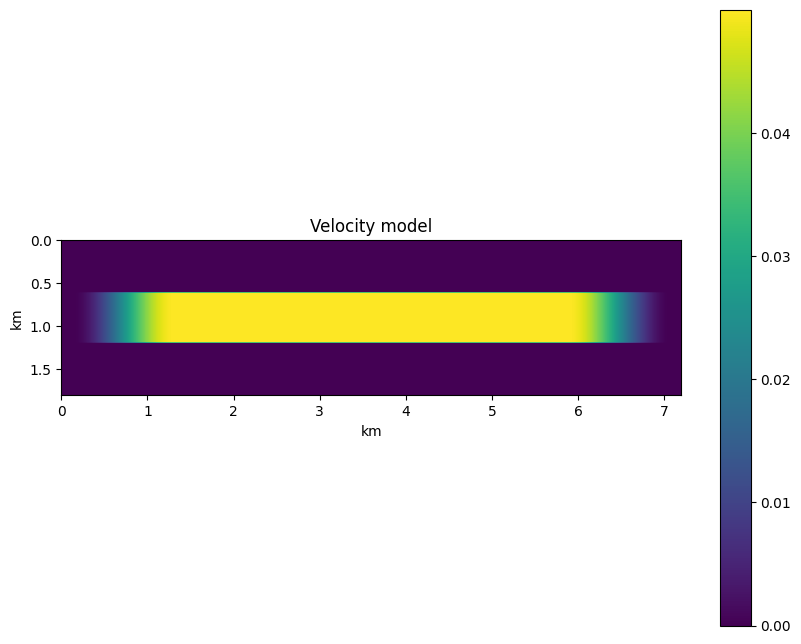

In [6]:
plot_table(inp_flat.T,'Velocity model')


In [7]:
# Read the shot gathers from numerical modelling 
# Reads the data according to the parameters
if sel == 0:
    '''for dt = 1.41e-3'''
    fl3 = 'input/dt141_t1_obs_000301.dat'
    inp3 = readbin(fl3, no, nt)
    fl = 'input/dt141_wsrc.dat'
    nws = 143
else: 
    '''For dt = 0.35e-3 '''
    fl3 = 'input/dt035_t1_obs_000301.dat'
    inp3 = readbin(fl3, no, nt)
    fl =  'input/dt035_wsrc.dat'
    nws = 573
    
    
wsrc_num = readbin(fl, nws, 1)[:,0] # Wavelet of the numerical solution


# Select the trace to compare
tr3 = inp3[125]


# Definition of the source

In [8]:
def defwsrc(fmax, dt, lent):
    """
    Definition of the source function
    Ricker wavelet with central frequency fmax/2.5
    Ricker = 2nd-order derivative of a Gaussian function
    """
    fc = fmax / 2.5  # Central frequency
    ns2  = nws + lent # Classical definition
    ns = int((ns2-1)/2)  # Size of the source
    wsrc = np.zeros(ns2)
    for it in range(-ns,ns+1):
        a1 = float(it) * fc * dt * pi
        a2 = a1 ** 2     
        wsrc[it+ns] = (1 - 2 * a2) * exp(-a2)
    if len(wsrc) % 2 == 0 :
        print('The wavelet is even. The wavelet must be odd. \
        There must be the same number of samples on both sides of the maximum value')
    else: 
        print('Wavelet is odd = ' + str(len(wsrc)))
        return wsrc

In [9]:


# Parameters of the analytical source wavelet
fmax = 25
nt2 = nt - (nws-1) / 2
nt_len = int((nt2+1) * 2)
wsrc = defwsrc(fmax, dt,nt_len - nws+1)  # lengthen wavelet to nt of the numerical solution
wsrc_org = defwsrc(fmax, dt,0) # original wavelet


nf = len(wsrc)
aw2 = 2. * pi * np.fft.fftfreq(nf, dt)
wsrcf = np.fft.fft(wsrc)

diff_wsrc = wsrc_org - wsrc_num

Wavelet is odd = 2863
Wavelet is odd = 143


In [10]:
print(nws)
print(nt_len-nws)

143
2719


In [11]:
print('length of the source: ',len(wsrc))

length of the source:  2863


Text(0.5, 1.0, 'lengthen of the wavelet')

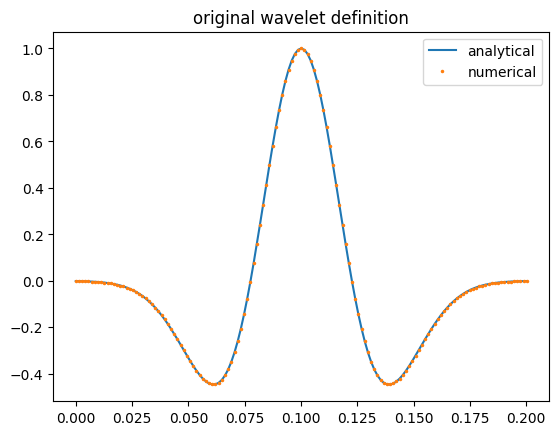

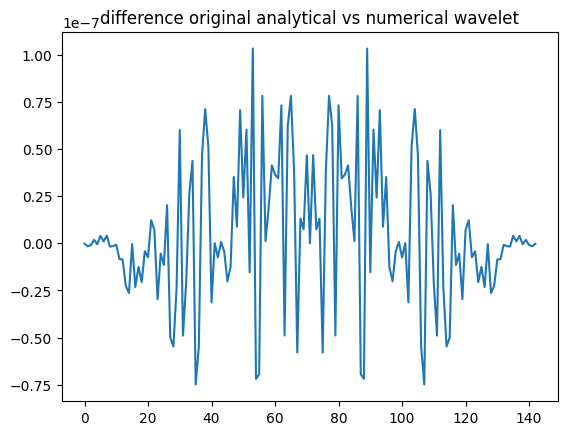

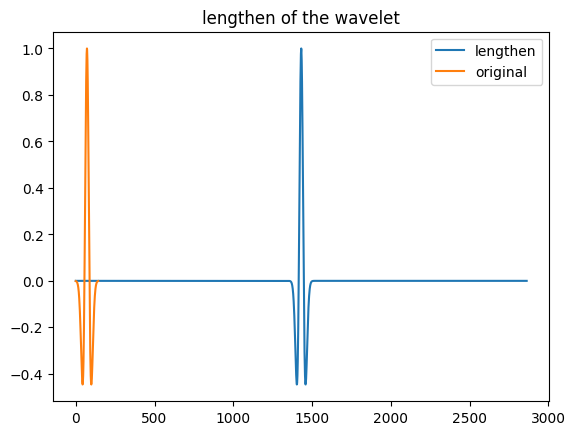

In [12]:
t = np.arange(len(wsrc_org))*dt
plt.figure()
plt.plot(t,wsrc_org,label = 'analytical')
plt.plot(t,wsrc_num,'.',markersize=3,label = 'numerical')
plt.legend()
plt.title('original wavelet definition')

plt.figure()
plt.plot(diff_wsrc)
plt.title('difference original analytical vs numerical wavelet')

# The wavelet has to be lenghten due to the arrival time higher than the source length
plt.figure()
plt.plot(wsrc,label = 'lengthen')
plt.plot(wsrc_org,markersize=3,label = 'original')
plt.legend()
plt.title('lengthen of the wavelet')



# Calculation of the distance

Distance between the source and receiver to any point in the model

In [13]:
def distance_to_spot(pos_x,pos_z):
    '''Calculates the distance to a given point in the model'''
    r = np.zeros((nx, nz))
    for i in range(nx):
        for k in range(nz):
            r[i, k] = np.sqrt((pos_x - ax[i]) ** 2 + (pos_z - az[k]) ** 2)
    return r

In [14]:
s_p = distance_to_spot(src_x,src_z)
p_r = distance_to_spot(rec_x,rec_z)

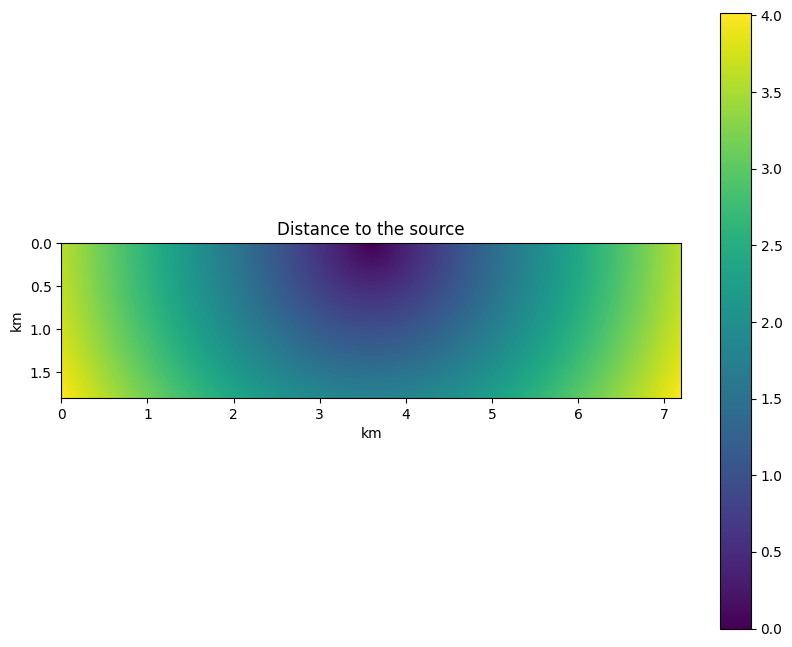

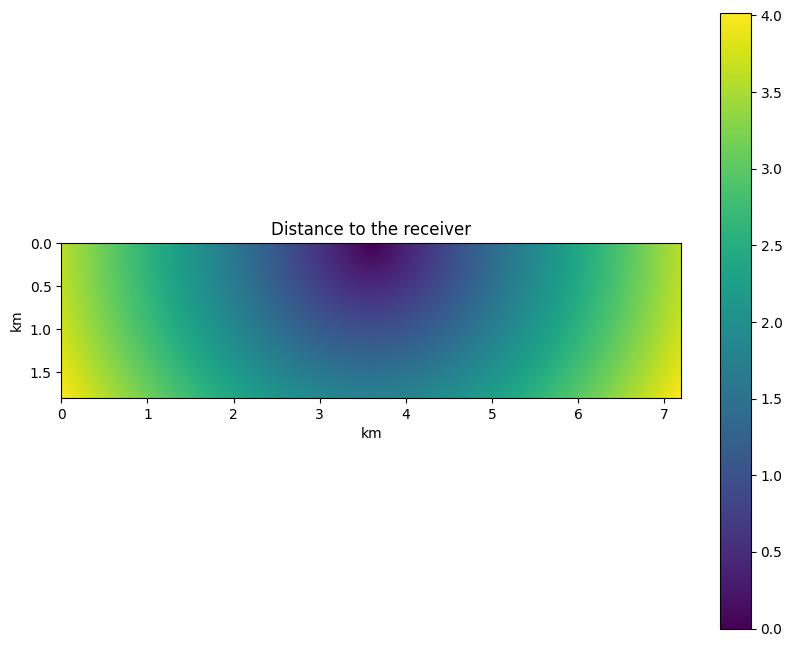

In [15]:
plot_table(s_p,'Distance to the source')
plot_table(p_r,'Distance to the receiver')

In [16]:
""" Parameters for modelling """
v0 = 2.000
delta_v_n = (2 * inp_flat.T) / v0 ** 3

# Hankel wave propagation before multiplication
We solve only this part of the integral:
$$ hk = \int\int H\left( -\omega  \frac{|s-p|}{v_0}\right)  \frac{2 \delta V(x)}{V_0³} H\left(-\omega \frac{|p-r|}{v_0}\right) dx dz$$

In [17]:
%%time
def hankel_wave_prop(d_src, d_rec, delta_v):
    
    hk = np.zeros((nf),dtype='complex')

    for ix in tqdm(range(0,nx)):
        for iz in range(51,99+1):
            hk += (1j / 4. * hankel1(0., d_src[ix, iz] * -aw2 / v0)) * delta_v[ix, iz]\
                    * (1j / 4. * hankel1(0., d_rec[ix, iz] * -aw2 / v0))
    return hk

CPU times: user 4 µs, sys: 5 µs, total: 9 µs
Wall time: 5.01 µs


In [18]:
%%time
'''Hankel wave propagation'''
hk = hankel_wave_prop(s_p, p_r, delta_v_n)
hk[0] = 0 # Replace nan by zero for $\omega = 0$

100%|█████████████████████████████████████████| 601/601 [00:29<00:00, 20.04it/s]

CPU times: user 30.1 s, sys: 121 ms, total: 30.2 s
Wall time: 30.1 s


# Solution of Hankel wave propagation
The result $hk$ is multiplied by the second derivative and the source term
$$\delta_p (s,r,\omega) = (i \omega)² \ S(\omega) \ hk $$ 

It is possible to not multiply by the second derivative
$$\require{cancel}$$  
$$\delta_p (s,r,\omega) = \cancel{(i \omega)²}  S(\omega) \ hk $$ 


In [19]:
%%time
wsrcf = np.fft.fft(wsrc)

# dp_f = hk * wsrcf * -(aw2**2)

dp_f = hk * wsrcf * (1j*aw2)**3

dp_t = np.real(np.fft.ifft(dp_f))

CPU times: user 1.58 ms, sys: 143 µs, total: 1.72 ms
Wall time: 1.04 ms


# Normalization
We need to normalize the data from both results to compare

In [42]:
def normalize(inp):
    """Normalize the data according to its maximum"""
    norm_inp = inp/np.max(abs(inp))
    return norm_inp
#     return inp

In [43]:
dp_t_norm = normalize(dp_t)

# Comparison of the source and the result of the Hankel $\delta_p$

- The result of the Hankel modeling is a shift of the wavelet in time
- This shift is the traveltime of the wave until the first and second reflection

Text(0.5, 1.0, 'Source and hankel result')

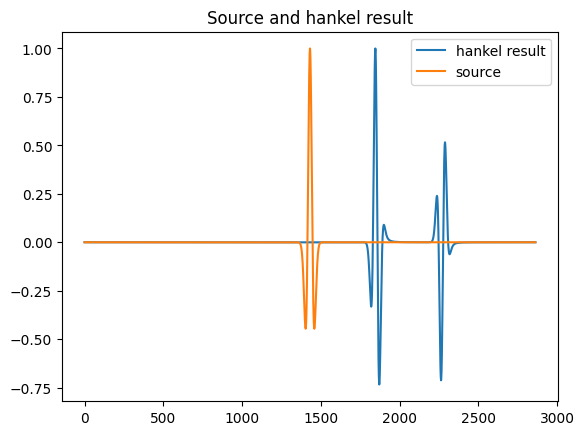

In [44]:
plt.plot(dp_t_norm,label='hankel result')
plt.plot(wsrc,label='source')
plt.legend()
plt.title('Source and hankel result')

# Repositionning 
- We need to reposition the result so that the events are on the right of the source maximum
- We shift the wavelet and the result so that the result is according to the wavelet $t=0$

In [45]:
# Find the shift between hankel result and trace
idx_src = np.argmax(wsrc)
idx_shift = np.argmax(wsrc) - np.argmax(dp_t_norm)

dp_t_corr = np.roll(dp_t_norm, idx_src)
wsrc_corr = np.roll(wsrc, idx_src)


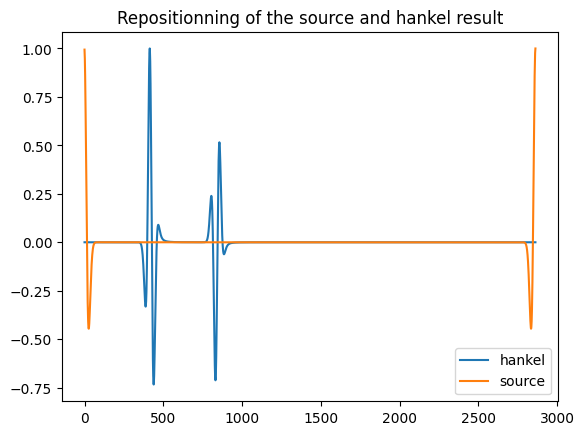

In [46]:
plt.plot(dp_t_corr, label='hankel')
plt.plot(wsrc_corr, label='source')
plt.title('Repositionning of the source and hankel result')
plt.legend()
plt.show()

# Comparison w/o time scale

- We plot the result of the Hankel modeling (analytical) overlaying the numerical solution

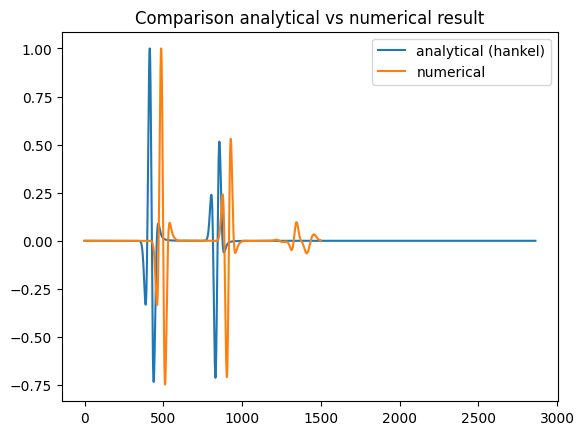

In [47]:
# Compare with the numerical result
tr3_norm = normalize(-tr3)
plt.plot(dp_t_corr, label='analytical (hankel)')
plt.plot(tr3_norm, label='numerical')
plt.title('Comparison analytical vs numerical result')
# plt.xlim(250,1100)
plt.legend()
plt.show()


In [48]:
print(np.max(np.abs(dp_t_corr))/ np.max(np.abs(tr3_norm)))
print(np.max(np.abs(tr3_norm)))


1.0
1.0


# Forced fit
- We decided to force the fit of the curves as they are not exactly at the same position
- The curves are fitted according to their maximum amplitude

In [49]:
def roll_idx_max(inp1,inp2):
    idx = np.argmax(abs(inp1)) - np.argmax(abs(inp2))
#     idx = np.argmax(inp1) - np.argmax(inp2)
    return idx

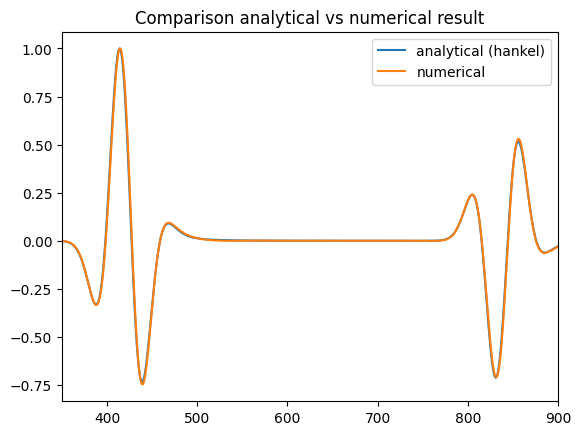

In [50]:
idx = roll_idx_max(tr3_norm,dp_t_corr)
tr3_norm_roll = np.roll(tr3_norm,-idx)

plt.plot(dp_t_corr, label='analytical (hankel)')
plt.plot(tr3_norm_roll, label='numerical')

plt.title('Comparison analytical vs numerical result')
plt.xlim(350,900)
plt.legend()

In [51]:
print(idx)

72


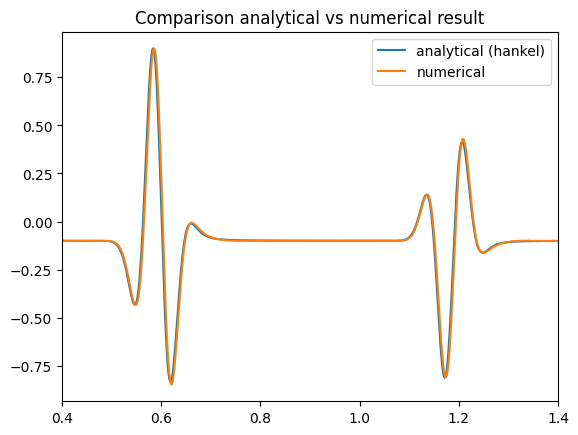

In [63]:
# # Compare with the numerical result with the correct time
'''Calculates actual times according to wavelet'''
tr3_norm = normalize(-tr3)
t = np.arange(len(wsrc))*dt
# at2 = np.arange(nt-1)*dt+ft
plt.plot(t,dp_t_corr+ft, label='analytical (hankel)')
plt.plot(at,tr3_norm+ft, label='numerical')
plt.title('Comparison analytical vs numerical result')
plt.xlim(0.4,1.4)
plt.legend()
plt.show()

# Phase rotation
Testing if a phase rotation can correct for the differences

In [53]:
def phase_rot(inp,fact):
    """Modification of the phase"""
    wsrcf = np.fft.rfft(inp,axis=-1)
    n     = len(wsrcf)
    #     fact  = np.pi/4
    wsrcf *= np.exp(1j*fact)
    mod_ph = np.fft.irfft(wsrcf,axis=-1)
    return mod_ph

def force_phase_fit(inp_ph,inp_org):
    idx = roll_idx_max(inp_ph,inp_org)
    ph_fit = normalize(np.roll(inp_ph,-idx))
    return ph_fit

In [54]:
# Rotation de phase pi/2
tr_ph90 = -phase_rot(tr3_norm,pi/2)
tr_ph90_fit = force_phase_fit(tr_ph90,dp_t_corr)

# Rotation de phase pi/4
tr_ph45 = -phase_rot(tr3_norm,pi/4)
tr_ph45_fit = force_phase_fit(tr_ph45,dp_t_corr)

# Rotation de phase pi
tr_ph180 = -phase_rot(tr3_norm,pi)
tr_ph180_fit = force_phase_fit(tr_ph180,dp_t_corr)



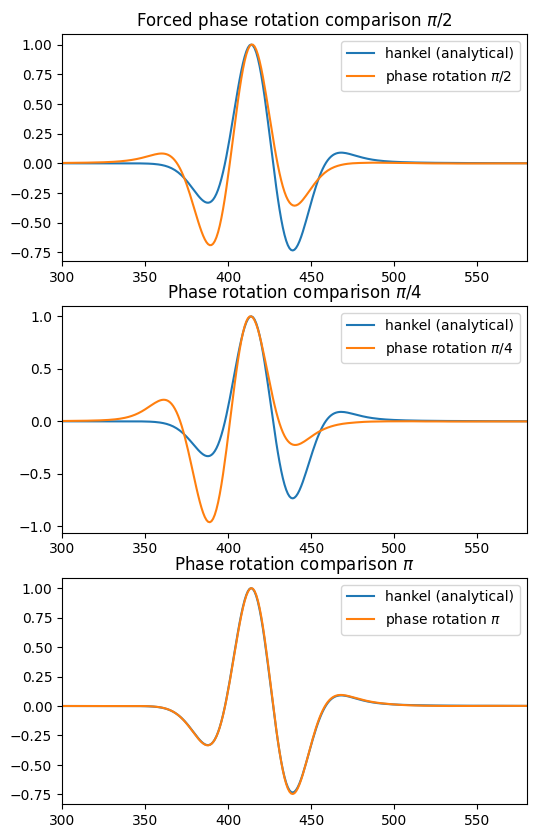

In [55]:
# plt.plot(tr_ph, label='numerical phase rot')
fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, ncols=1,
                                    figsize=(6, 10))

# ax1 = plt.subplot(311)
ax1.plot(dp_t_corr, label='hankel (analytical)')
ax1.plot(tr_ph90_fit, label='phase rotation $\pi/2$')
ax1.set_title('Forced phase rotation comparison $\pi/2$')
ax1.set_xlim(300,580)
# ax1.set_xlim(0,1100)
ax1.legend()


# plt.plot(tr_ph, label='numerical phase rot')
# ax2 = plt.subplot(312)
ax2.plot(dp_t_corr, label='hankel (analytical)')
ax2.plot(tr_ph45_fit, label='phase rotation $\pi/4$')
ax2.set_title('Phase rotation comparison $\pi/4$')
ax2.set_xlim(300,580)
# ax2.set_xlim(0,1100)
ax2.legend()

# ax3 = plt.subplot(313)
ax3.plot(dp_t_corr, label='hankel (analytical)')
ax3.plot(tr_ph180_fit, label='phase rotation $\pi$')
ax3.set_title('Phase rotation comparison $\pi$')
ax3.set_xlim(300,580)
# ax3.set_xlim(0,1100)
ax3.legend()


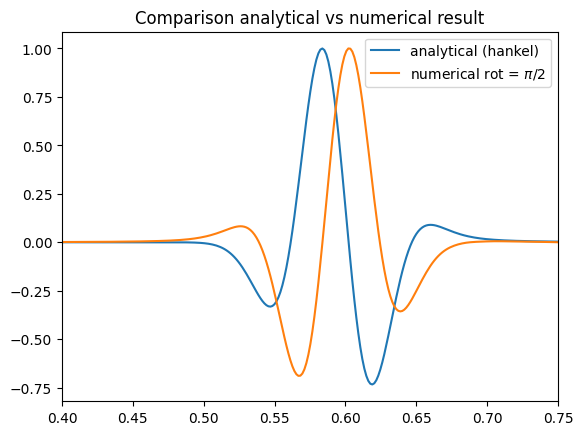

In [56]:
# # Calculating the right time
'''Calculates actual times according to wavelet after phase rotation'''

t = np.arange(len(wsrc))*dt
# at2 = np.arange(nt-1)*dt+ft
plt.plot(t,dp_t_corr, label='analytical (hankel)')
plt.plot(at[:-1],normalize(tr_ph90), label='numerical rot = $\pi/2$')
plt.title('Comparison analytical vs numerical result')
plt.xlim(0.4,0.75)
plt.legend()

# Hilbert transform

The hilbert transform produces a phase rotation

In [57]:
def hilbert_transform(inp):
    hilb_new = hilbert(inp)
    hilb_new = hilb_new.imag
    hilb_new = normalize(hilb_new)
    return hilb_new

In [58]:
hb_tr = hilbert_transform(tr3_norm)
idx3 = roll_idx_max(hb_tr,dp_t_corr)
tr_hb_roll = np.roll(hb_tr,-idx3)

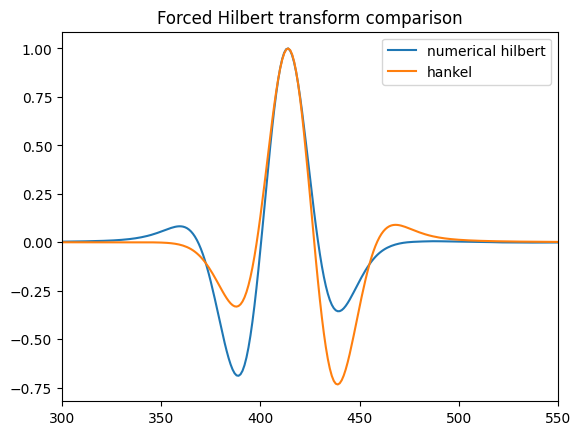

In [59]:
plt.plot(tr_hb_roll, label='numerical hilbert')
plt.plot(dp_t_corr, label='hankel')
plt.title('Forced Hilbert transform comparison')

plt.xlim(300,550)
plt.legend()
plt.show()

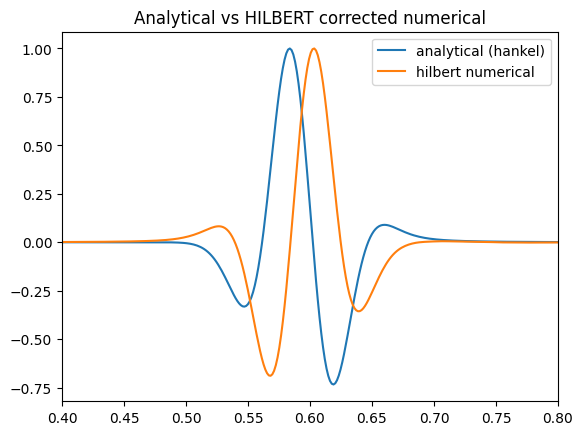

In [60]:
# # Calculating the right time
'''Calculates actual times according to wavelet with hilbert transform applied to the data'''

t = np.arange(len(wsrc))*dt
plt.plot(t,dp_t_corr, label='analytical (hankel)')
plt.plot(at,normalize(hb_tr), label='hilbert numerical')
plt.title('Analytical vs HILBERT corrected numerical')
plt.xlim(0.4,0.8)
plt.legend()



In [61]:
%whos

Variable            Type                          Data/Info
-----------------------------------------------------------
ao                  ndarray                       251: 251 elems, type `float64`, 2008 bytes
at                  ndarray                       1501: 1501 elems, type `float64`, 12008 bytes
at2                 ndarray                       1500: 1500 elems, type `float64`, 12000 bytes
aw2                 ndarray                       2863: 2863 elems, type `float64`, 22904 bytes
ax                  ndarray                       601: 601 elems, type `float64`, 4808 bytes
ax1                 AxesSubplot                   AxesSubplot(0.125,0.653529;0.775x0.226471)
ax2                 AxesSubplot                   AxesSubplot(0.125,0.381765;0.775x0.226471)
ax3                 AxesSubplot                   AxesSubplot(0.125,0.11;0.775x0.226471)
az                  ndarray                       151: 151 elems, type `float64`, 1208 bytes
defwsrc             function          